# Concrete Complexities

In [1]:
from math import inf, comb as binom, log2, factorial
from cryptographic_estimators.SDFqEstimator import SDFqEstimator

def gv_distance(n,k,q):
    """
    Gilbert - Varshamov distance of a code over Fq, with length n and dimension k
    """
    d = 1
    right_term = q**(n-k)
    left_term = 0
    while left_term <= right_term:
        left_term += binom(n,d)*(q-1)**d
        d+=1

    return d

def time_new(n,k,q, verbose=1, lowerbound=-1, output_all_data=0):
    """
    Concrete time complexity of 
    - Algorithm 4 (lowerbound=-1)
    - Lowerbound for codeword-finding based algorithms(lowerbound=1)
    - Semi-Lowerbound assuming |Z|<|V| (lowerbound = 0)    
    """
    mini=100000000
    prev=2**12
    wmin=gv_distance(n,k,q)
    for w in range(wmin,n-k):
        ell=int(w**2/n)  
        Nw =log2(binom(n,w))+log2(q-1)*w-log2(q)*(n-k)
        
        # required number of codewords
        Li = Nw/2+0.5-log2(q-1)/2
        
        # time to find codewords
        time_codeword_finding = SDFqEstimator(n,k,w,q).fastest_algorithm().time_complexity()+Li+1
        
        # list size of all pairs
        V_W =2*Li
        
        # meet in the middle on scalar
        V_W_enlarged = V_W + log2(q-1)/2

        # upper bound on Z
        perms = log2(factorial(ell))
        Z = max(0,2*V_W_enlarged+perms-ell*log2(q-1))


        T_SSP_Recover_Monomial = log2(n)*4
        T_op = log2(log2(q))*2
        T_Criterion = log2(2*n+ell)
        if lowerbound == -1:
            #regular algorithm
            T_Compatible_Pairs = max(1 + V_W_enlarged + T_Criterion, Z + log2(4*n))
            # print(time_recovery)
        elif lowerbound ==0:
            #compatibility linear
            T_Compatible_Pairs = 1 + V_W_enlarged + T_Criterion
        elif lowerbound ==1:
            #lower bound
            T_Compatible_Pairs = 1 + Li
        
        repitions = log2(1/(1/2*0.94))
        tmp = repitions+ max(time_codeword_finding,T_op + max(T_Compatible_Pairs, Z + T_SSP_Recover_Monomial))
        
        #early abort
        if tmp>prev:
            break
        else:
            prev=tmp
            
        if tmp<mini:
            mini=tmp
            par=w
            times = time_codeword_finding,T_op + T_Compatible_Pairs,T_op+Z + T_SSP_Recover_Monomial
            paramint=w,Li,V_W,Z,T_SSP_Recover_Monomial,T_Criterion, SDFqEstimator(n,k,w,q,nsolutions=0).stern.time_complexity()-Nw,T_Compatible_Pairs,mini

    if verbose:
        print(paramint)
        print(mini,times, par)
    return mini

In [2]:
def cf_mitm_concrete(n,k,q):
    """
    Concrete complexity of CFMITM algorithm
    """
    return log2(binom(n,n-k))/2+log2(k)*2 + log2(n)+2*log2(log2(q))

### LCE instances

In [3]:
from cryptographic_estimators.LEEstimator import LEEstimator
from prettytable import PrettyTable
def ri(x):
    if x == inf:
        return "-"
    return int(round(x))

row_header = ["(n,k,q)","CFMITM","Leon","Beullens","BBPS", "New"]
t = PrettyTable(row_header)

for par in [[252,126,127],[400,200,127],[548,274,127],[198,94,251]]:
    n,k,q=par
    new = time_new(n,k,q,verbose=0,lowerbound=-1)
    low0 = time_new(n,k,q,verbose=0,lowerbound=0)
    low1 = time_new(n,k,q,verbose=0,lowerbound=1)
    
    A=LEEstimator(n,k,q)
    beu = A.beullens.time_complexity()
    leo = A.leon.time_complexity()
    bbps = A.bbps.time_complexity()
    cf = cf_mitm_concrete(n,k,q)
        
    name = params= "("+str(n)+","+str(k)+","+str(q)+")"
    row = [name,ri(cf),ri(leo),ri(beu),ri(bbps),ri(new)]
    t.add_row(row)

print(t)

+---------------+--------+------+----------+------+-----+
|    (n,k,q)    | CFMITM | Leon | Beullens | BBPS | New |
+---------------+--------+------+----------+------+-----+
| (252,126,127) |  151   | 153  |   142    | 139  | 127 |
| (400,200,127) |  227   | 230  |   232    | 214  | 195 |
| (548,274,127) |  302   | 307  |   324    | 290  | 266 |
|  (198,94,251) |  123   | 134  |   113    | 114  | 107 |
+---------------+--------+------+----------+------+-----+


### Permutation Equivalence Instances

In [7]:
from cryptographic_estimators.PEEstimator import PEEstimator

perm_eq= [[252,126,127],[400,200,127],[548,274,127],[235,108,251],[230,115,127]]
row_header = ["(n,k,q)","CFMITM","Leon","Beullens", "New"]
t = PrettyTable(row_header)

for i in perm_eq:
    n,k,q=i
    
    new = time_new(n,k,q,verbose=0,lowerbound=-1)
    low0 = time_new(n,k,q,verbose=0,lowerbound=0)
    low1 = time_new(n,k,q,verbose=0,lowerbound=1)
    
    A=PEEstimator(n,k,q)
    beu = A.beullens.time_complexity()
    leo = A.leon.time_complexity()
    cf = cf_mitm_concrete(n,k,q)

    name= "("+str(n)+","+str(k)+","+str(q)+")"
    row =[name,ri(cf),ri(leo),ri(beu),ri(new)]
    t.add_row(row)
print(t)

+---------------+--------+------+----------+-----+
|    (n,k,q)    | CFMITM | Leon | Beullens | New |
+---------------+--------+------+----------+-----+
| (252,126,127) |  151   | 153  |   129    | 127 |
| (400,200,127) |  227   | 230  |   195    | 195 |
| (548,274,127) |  302   | 307  |   263    | 266 |
| (235,108,251) |  142   | 154  |   125    | 124 |
| (230,115,127) |  140   | 142  |   119    | 117 |
+---------------+--------+------+----------+-----+


In [8]:
time_new(198,94,251) 

(91, 40.90442443642585, 81.8088488728517, 9.502918188016508, 30.517426480318438, 8.7714894695006, 64.18907405931341, 95.56323048468333, 107.02242268123591)
107.02242268123591 (105.93315534313882, 101.55294869397247, 46.01006287762408) 91


107.02242268123591

### Plot Concrete Complexities

In [9]:
Lnew=[]
Llow1=[]
Llow0=[]
Lbeu=[]
Lleo=[]
Lbbps=[]
Lcf=[]

n=252
k=126

for i in range(5,250,2):
    new = time_new(n,k,i,verbose=0,lowerbound=-1)
    low0 = time_new(n,k,i,verbose=0,lowerbound=0)
    low1 = time_new(n,k,i,verbose=0,lowerbound=1)
    Lnew.append([i,new])
    Llow0.append([i,low0])
    Llow1.append([i,low1])
    
    A=LEEstimator(n,k,i)
    beu = A.beullens.time_complexity()
    leo = A.leon.time_complexity()
    bbps = A.bbps.time_complexity()
    Lbeu.append([i,beu])
    Lleo.append([i,leo])
    Lbbps.append([i,bbps])
    
    cf = cf_mitm_concrete(n,k,i)
    Lcf.append([i,cf])

In [10]:
Lbeu= [[j[0],j[1]] for j in Lbeu if j[1]!=inf]
Lbbps= [[j[0],j[1]] for j in Lbbps if j[1]!=inf]

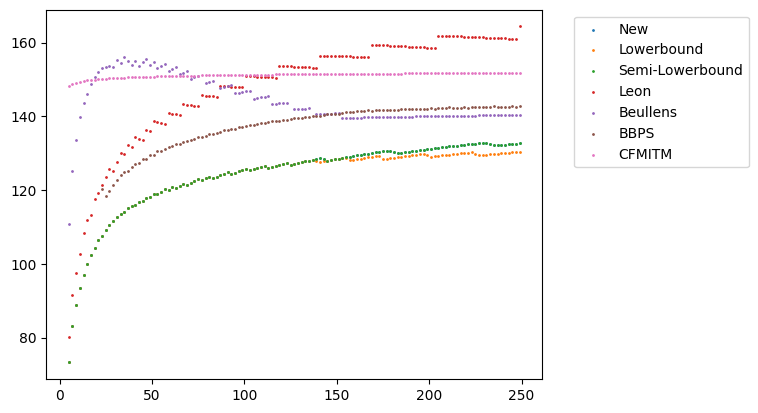

In [11]:
import matplotlib.pyplot as plt
def plot(L,label_list):
    """
    function to plot list of lists of the form L=[L1,L2,...] with Li=[[x1,y1],[x2,y2],...]
    """
    c=0
    for Li in L:
        x,y=zip(*Li)
        plt.scatter(x,y, label=label_list[c],s=1)
        c+=1
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
plot([Lnew,Llow1,Llow0,Lleo,Lbeu,Lbbps,Lcf],["New","Lowerbound", "Semi-Lowerbound","Leon","Beullens","BBPS","CFMITM"])